In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
37191,NaN,NaN,International,2020-03-01,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37192,NaN,NaN,International,2020-03-02,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37193,NaN,NaN,International,2020-03-10,696.0,-9.0,7.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


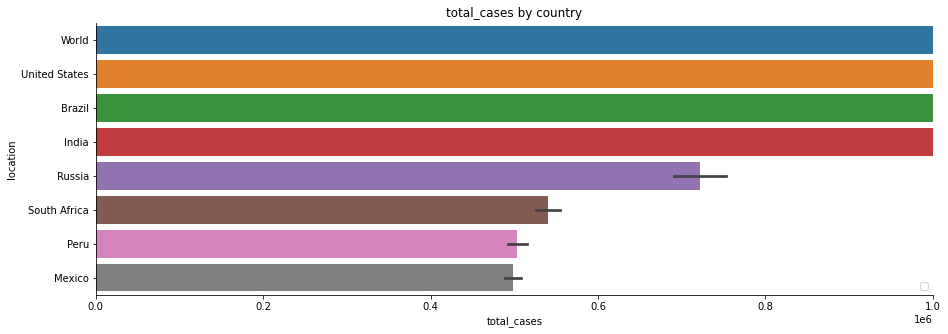

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


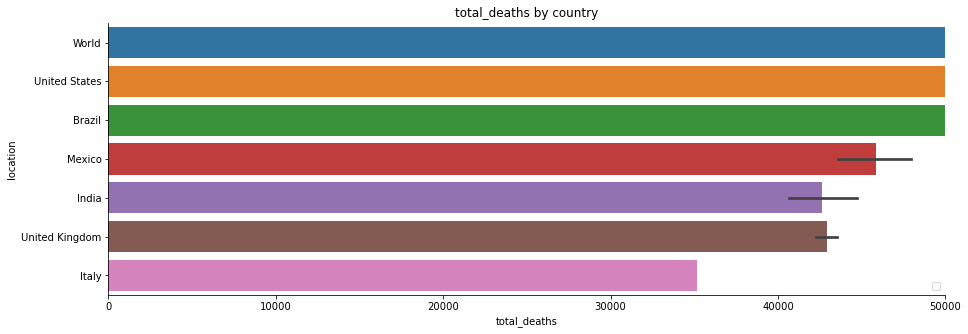

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


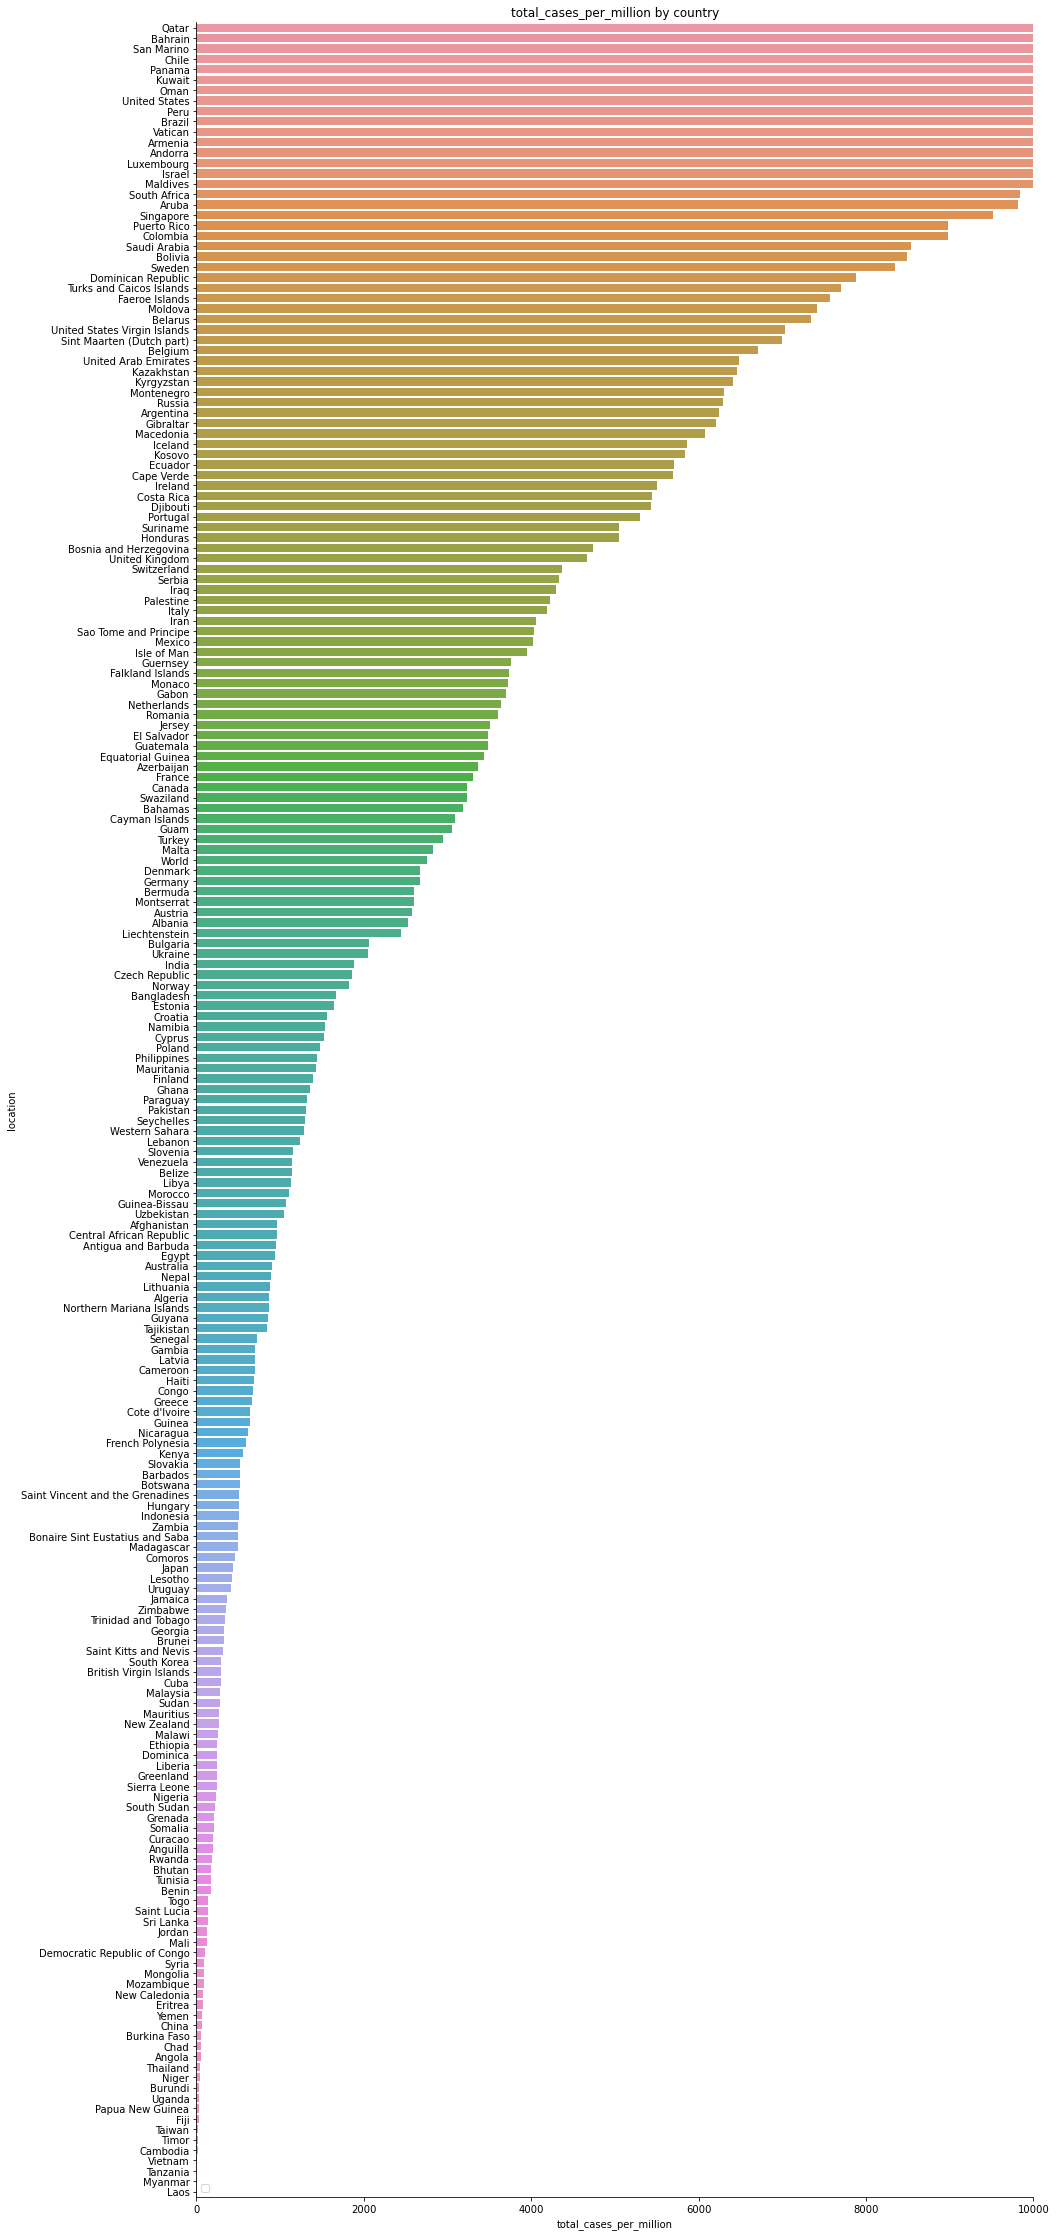

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


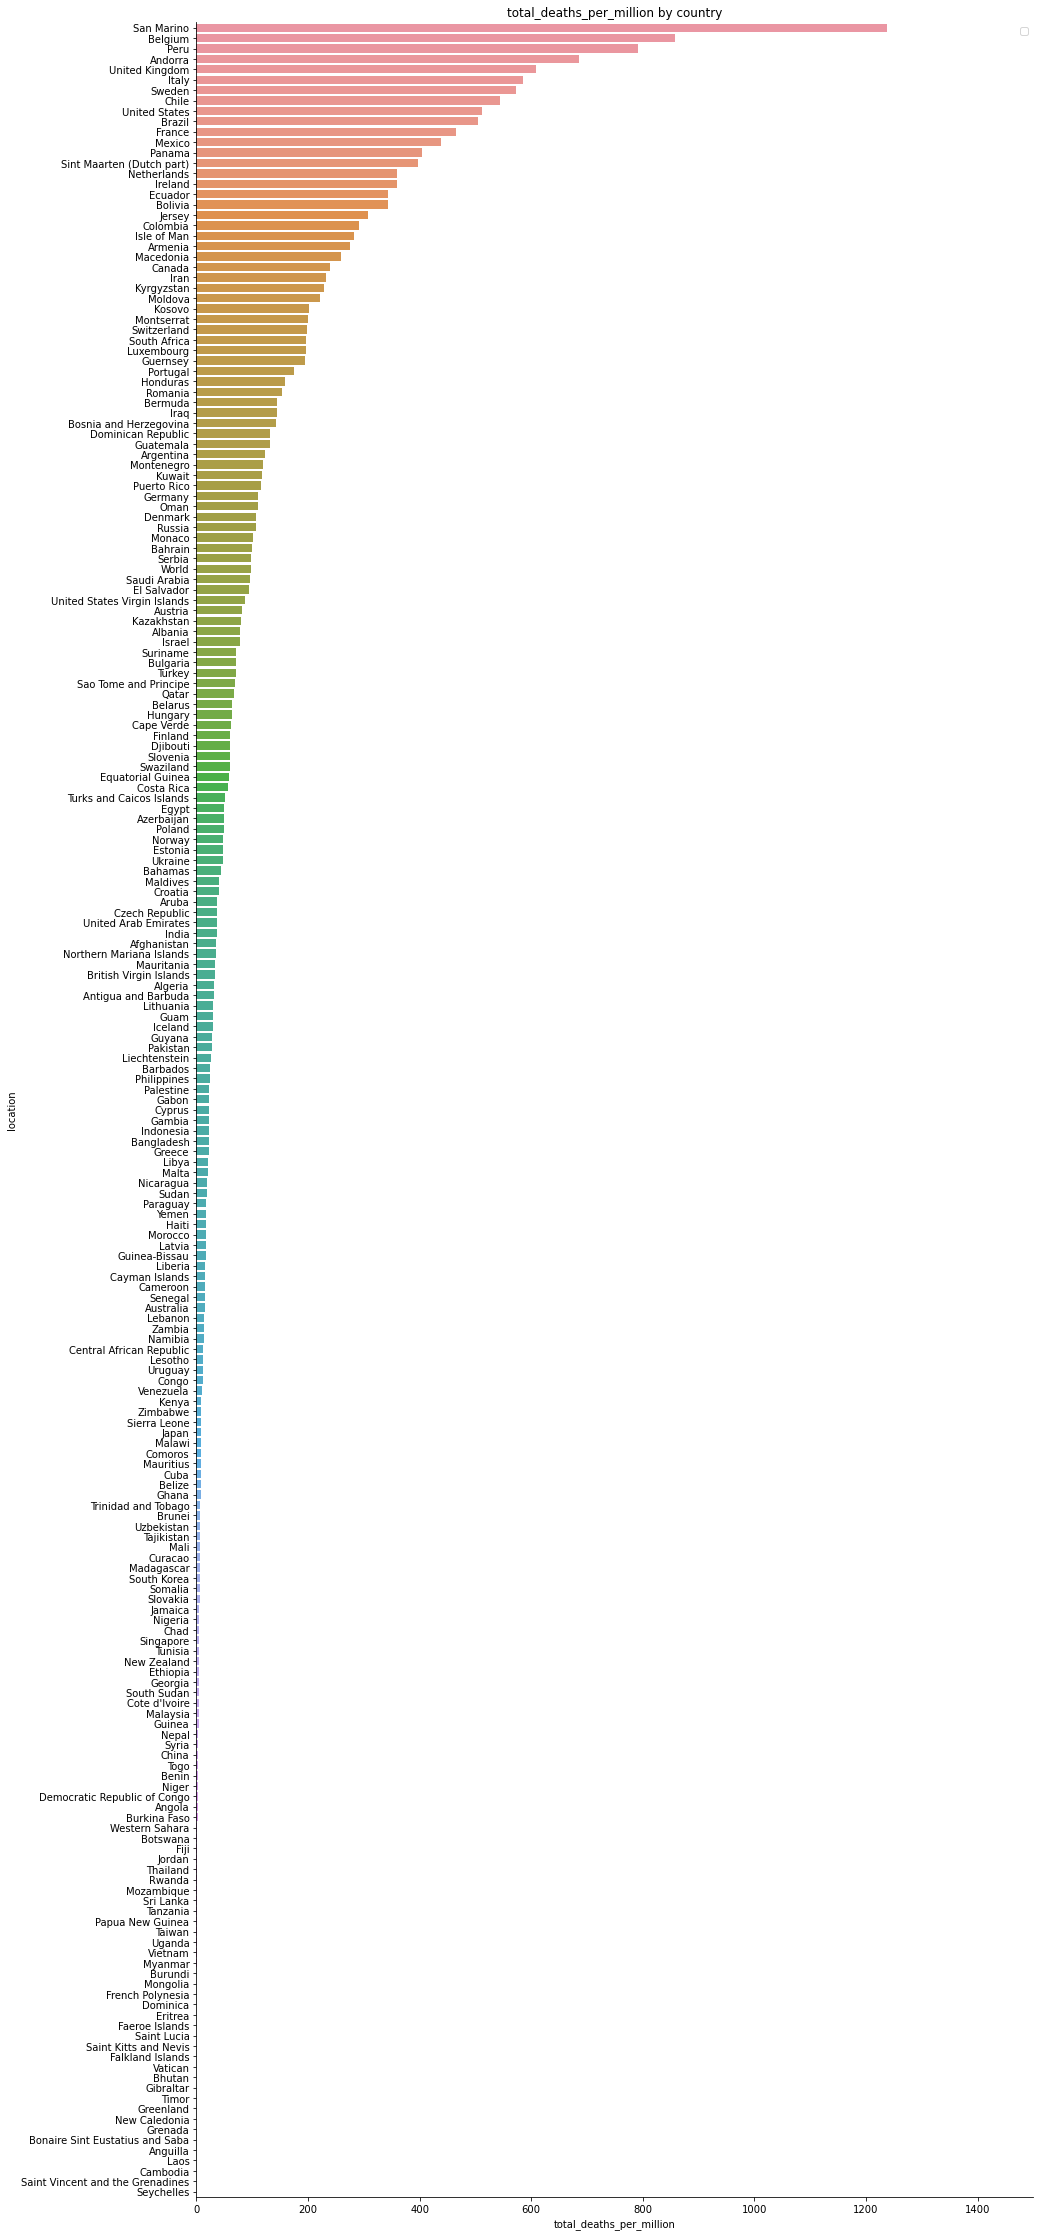

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

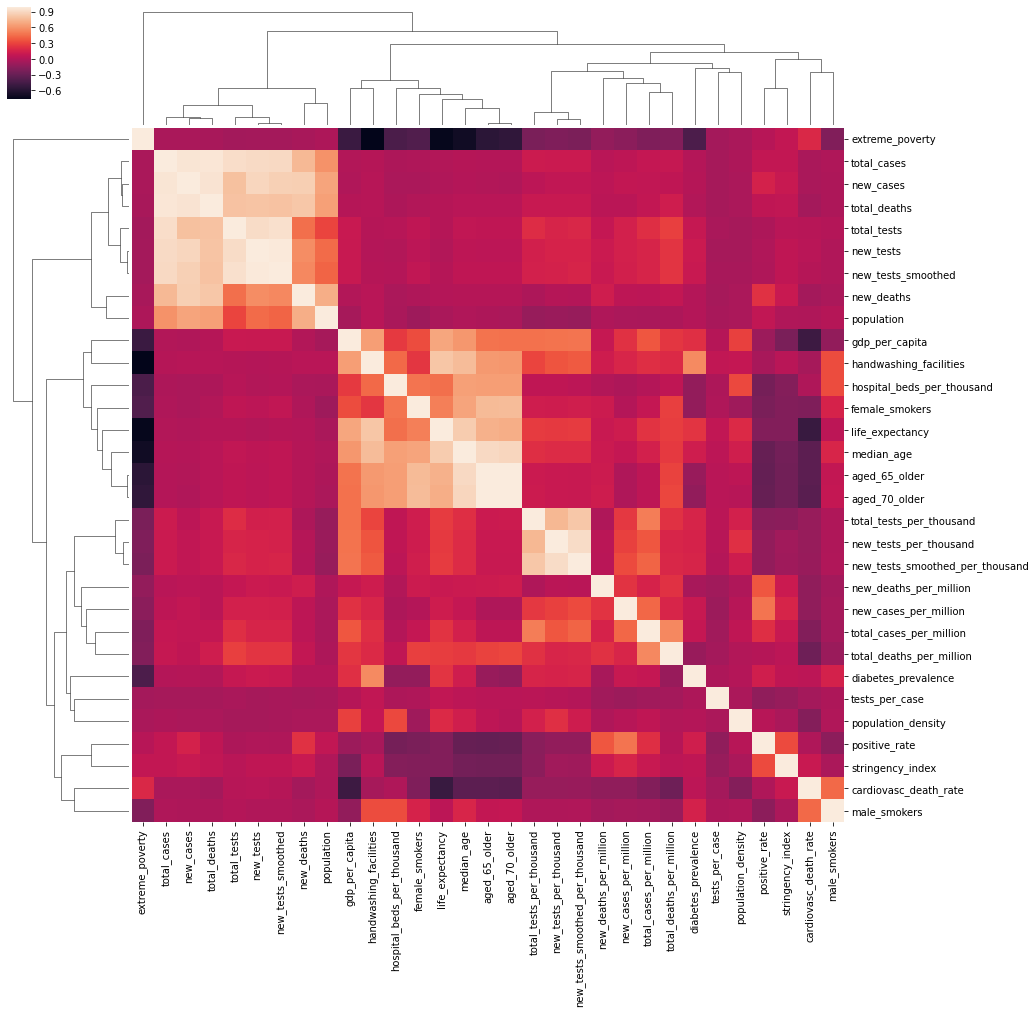

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996147682871509 (+/- 0.00020289082623566013)
Coef :  [1.04340251e+00 7.97404761e-05 8.39914395e-05]
3 Last_days :  [[20925687 21214496 21472570]]
Today :  21472570
Prediction + :  429400
Tomorow :  21901970
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995546333339697 (+/- 8.963538811367375e-05)
Coef :  [-0.10124725  0.53813141  0.57281775]
3 Last_days :  [[754185 760433 766080]]
Today :  766080
Prediction + :  7704
Tomorow :  773784
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9717845803451102 (+/- 0.030218975297590468)
Coef :  [-0.67495467  0.73637639  0.93938059]
3 Last_days :  [[209365 212211 215521]]
Today :  215521
Prediction + :  2201
Tomorow :  217722
                                     
--------- Total Death -----------------
                                     
R^2: 0.4070838398232284 (+/- 0.8240693213418672)
Coef :  [-0.75577037  0.78832732  0.9665789 ]
3 Last_days :  [[30388 30406 30409]]
Today :  30409
Prediction + :  38
Tomorow :  30447
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7894107235425597 (+/- 0.1519044196890637)
Coef :  [-0.3211164  -0.02620026  1.34158779]
3 Last_days :  [[89144 89214 89279]]
Today :  89279
Prediction + :  62
Tomorow :  89341
                                     
--------- Total Death -----------------
                                     
R^2: -1650.7501917167444 (+/- 2335.603568400707)
Coef :  [-0.0765061   0.01240601  1.05617329]
3 Last_days :  [[4700 4701 4703]]
Today :  4703
Prediction + :  7
Tomorow :  4710
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7675004630636155 (+/- 0.32724368650973457)
Coef :  [-0.83850571  0.90547756  0.93224533]
3 Last_days :  [[252235 252809 253438]]
Today :  253438
Prediction + :  607
Tomorow :  254045
                                     
--------- Total Death -----------------
                                     
R^2: 0.9055566814229139 (+/- 0.10753589465450576)
Coef :  [-0.83632319  0.90386458  0.93171202]
3 Last_days :  [[35231 35234 35392]]
Today :  35392
Prediction + :  16
Tomorow :  35408
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7477815278140412 (+/- 0.34669804196334875)
Coef :  [-0.72916242  0.76586631  0.96359549]
3 Last_days :  [[337334 342813 342813]]
Today :  342813
Prediction + :  4537
Tomorow :  347350
                                     
--------- Total Death -----------------
                                     
R^2: -0.5342977094545294 (+/- 1.014066552337605)
Coef :  [-0.71621642  0.60581805  1.10940246]
3 Last_days :  [[28605 28617 28617]]
Today :  28617
Prediction + :  17
Tomorow :  28634
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9975836678388839 (+/- 0.00308039566372504)
Coef :  [0.09737084 0.46005643 0.46333703]
3 Last_days :  [[5248242 5313080 5361165]]
Today :  5361165
Prediction + :  88630
Tomorow :  5449795
                                     
--------- Total Death -----------------
                                     
R^2: 0.48363875639112025 (+/- 0.7286752792466918)
Coef :  [-0.64439718  0.77562931  0.87094699]
3 Last_days :  [[167110 168446 169481]]
Today :  169481
Prediction + :  1332
Tomorow :  170813
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.983974998016747 (+/- 0.020981275888426323)
Coef :  [-0.78469802  0.87888451  0.90587863]
3 Last_days :  [[314927 316367 316367]]
Today :  316367
Prediction + :  1577
Tomorow :  317944
                                     
--------- Total Death -----------------
                                     
R^2: 0.3049885694907513 (+/- 0.6901249536670353)
Coef :  [-0.45239442  0.31679588  1.1348403 ]
3 Last_days :  [[41347 41357 41358]]
Today :  41358
Prediction + :  64
Tomorow :  41422
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9811472993370858 (+/- 0.024430552452401333)
Coef :  [-0.81554657  0.86793129  0.94715305]
3 Last_days :  [[221413 222828 223453]]
Today :  223453
Prediction + :  1308
Tomorow :  224761
                                     
--------- Total Death -----------------
                                     
R^2: 0.4426011158250717 (+/- 0.7769911201207461)
Coef :  [-0.79806179  0.84284991  0.95463534]
3 Last_days :  [[9225 9231 9231]]
Today :  9231
Prediction + :  12
Tomorow :  9243
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.07407812320225811 (+/- 1.3089498045441856)
Coef :  [0.15501388 0.42995904 0.42815616]
3 Last_days :  [[336324 338825 341070]]
Today :  341070
Prediction + :  3932
Tomorow :  345002
                                     
--------- Total Death -----------------
                                     
R^2: 0.8887510419359007 (+/- 0.15698047742117197)
Coef :  [-0.06093817  0.54105928  0.53398764]
3 Last_days :  [[19162 19331 19492]]
Today :  19492
Prediction + :  246
Tomorow :  19738
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9974749281003715 (+/- 0.0033149819255734823)
Coef :  [-0.76338399  0.86015804  0.90040389]
3 Last_days :  [[245635 246861 248117]]
Today :  248117
Prediction + :  1075
Tomorow :  249192
                                     
--------- Total Death -----------------
                                     
R^2: 0.999502842975945 (+/- 0.0003692643729038526)
Coef :  [-0.82554501  0.90176667  0.92080369]
3 Last_days :  [[5912 5934 5955]]
Today :  5955
Prediction + :  19
Tomorow :  5974
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4629901301563743 (+/- 0.7563962564236735)
Coef :  [-0.15323954  0.47870907  0.69458533]
3 Last_days :  [[3224876 3275520 3317096]]
Today :  3317096
Prediction + :  65391
Tomorow :  3382487
                                     
--------- Total Death -----------------
                                     
R^2: 0.5058743628401839 (+/- 0.6936959026223363)
Coef :  [-0.20720833  0.55505255  0.6656645 ]
3 Last_days :  [[105463 106523 107232]]
Today :  107232
Prediction + :  1622
Tomorow :  108854
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(21472570, 766080, 21901970, 773784),
 (215521, 30409, 217722, 30447),
 (253438, 35392, 254045, 35408),
 (342813, 28617, 347350, 28634),
 (5361165, 169481, 5449795, 170813),
 (89279, 4703, 89341, 4710),
 (316367, 41358, 317944, 41422),
 (223453, 9231, 224761, 9243),
 (341070, 19492, 345002, 19738),
 (248117, 5955, 249192, 5974),
 (3317096, 107232, 3382487, 108854)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-16,France,217722.0,0.0,30447.0,0.0,0.0,0.0
0,2020-08-16,China,89341.0,0.0,4710.0,0.0,0.0,0.0
0,2020-08-16,Italy,254045.0,0.0,35408.0,0.0,0.0,0.0
0,2020-08-16,Spain,347350.0,0.0,28634.0,0.0,0.0,0.0
0,2020-08-16,United States,5449795.0,0.0,170813.0,0.0,0.0,0.0
0,2020-08-16,World,21901970.0,0.0,773784.0,0.0,0.0,0.0
0,2020-08-16,United Kingdom,317944.0,0.0,41422.0,0.0,0.0,0.0
0,2020-08-16,Germany,224761.0,0.0,9243.0,0.0,0.0,0.0
0,2020-08-16,Iran,345002.0,0.0,19738.0,0.0,0.0,0.0
0,2020-08-16,Turkey,249192.0,0.0,5974.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")